<a href="https://colab.research.google.com/github/abbas-aljawad/Machine-Learning/blob/master/Final_Project_COVID_DETECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 50 total images, equally split with 25 images of COVID-19 positive X-rays and 25 images of healthy patient X-rays

we will be tuning a Convolutional Neural Network to automatically diagnose COVID-19 using Keras, TensorFlow, and deep learning.

first we will take care of the necessary packages to import
TensorFlow 2.0 and Keras deep learning libraries via a selection of tensorflow.keras imports
matplotlib for plotting, and OpenCV for loading and preprocessing images in the dataset.

In [ ]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

data_set_path='/content/drive/My Drive/ML_COVID_classifier/dataset'
plot_path='/content/drive/My Drive/ML_COVID_classifier/plot.png'
mol_p='/content/drive/My Drive/ML_COVID_classifier/covid19.model'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:


# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-3
EPOCHS = 25
BS = 8

we will  preprocess our X-ray data
Extract the class label (either covid or normal) from the path of each image
to shape the image in orderto be ready to be inserted as aninput for the CNN it will be resized to 224x224 and converted to RGB ordering.
We then scale pixel intensities to the range [0, 1] and convert both our data and labels to NumPy array format

In [ ]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
imagePaths = list(paths.list_images(data_set_path))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]
	# load the image, swap color channels, and resize it to be a fixed
	# 224x224 pixels while ignoring aspect ratio
	image = cv2.imread(imagePath)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (224, 224))
	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 1]
data = np.array(data) / 255.0
labels = np.array(labels)

[INFO] loading images...


create our training and testing splits

In [ ]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)
# initialize the training data augmentation object
trainAug = ImageDataGenerator(
	rotation_range=15,
	fill_mode="nearest")


 initialize our VGGNet model
 instantiate the VGG16 network with weights pre-trained on ImageNet, leaving off the FC layer head.
From there, we construct a new fully-connected layer head consisting of POOL => FC = SOFTMAX layers and append it on top of VGG16.

In [ ]:
# load the VGG16 network, ensuring the head FC layer sets are left
# off
baseModel = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [ ]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the head of the network
print("[INFO] training head...")
H = model.fit_generator(
	trainAug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/25
5/5 [==============================] - 21s 4s/step - loss: 0.2794 - accuracy: 0.9750 - val_loss: 0.4307 - val_accuracy: 0.8000
Epoch 2/25
5/5 [==============================] - 21s 4s/step - loss: 0.3244 - accuracy: 0.9000 - val_loss: 0.4057 - val_accuracy: 0.8000
Epoch 3/25
5/5 [==============================] - 21s 4s/step - loss: 0.2576 - accuracy: 0.9500 - val_loss: 0.4156 - val_accuracy: 0.8000
Epoch 4/25
5/5 [==============================] - 21s 4s/step - loss: 0.2576 - accuracy: 0.9500 - val_loss: 0.4074 - val_accuracy: 0.8000
Epoch 5/25
5/5 [==============================] - 21s 4s/step - loss: 0.2982 - accuracy: 0.9000 - val_loss: 0.4006 - val_accuracy: 0.8000
Epoch 6/25
5/5 [==============================] - 21s 4s/step - loss: 0.2542 - accuracy: 0.9250 - val_loss: 0.3773 - val_accuracy: 0.8000
Epoch 7/25
5/5 [==============================] - 21s 4s/step - loss: 0.2603 - accuracy: 0.9250 - val_loss: 0.3679 - val_a

evaluate the model

In [ ]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

       covid       0.71      1.00      0.83         5
      normal       1.00      0.60      0.75         5

    accuracy                           0.80        10
   macro avg       0.86      0.80      0.79        10
weighted avg       0.86      0.80      0.79        10



Generate a confusion matrix 
Use the confusion matrix to derive the accuracy, sensitivity, and specificity and print each of these metrics.

In [ ]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[5 0]
 [2 3]]
acc: 0.8000
sensitivity: 1.0000
specificity: 0.6000


We then plot our training accuracy/loss history for inspection, outputting the plot to an image file

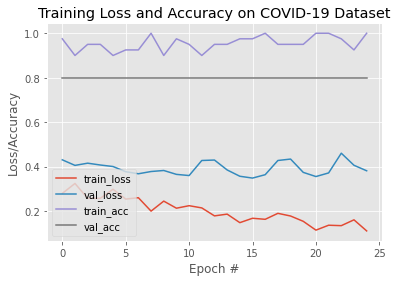

In [ ]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('/content/drive/My Drive/ML_COVID_classifier/plot.png')

Finally we serialize our tf.keras COVID-19 classifier model to disk

In [ ]:
# serialize the model to disk
print("[INFO] saving COVID-19 detector model...")
model.save(args["model"], save_format="h5")